# <center> EVOLUTIONARY COMPUTATION 
## <center> EvoEVOLUTION OF NEURAL NETWORKS
<center>
<img src="../imgs/logo.png" width="30%"></center>

## Motivation

<img src="../imgs/agent_representations.png" width="50%">

<!-- $\pi: s\rightarrow a$ -->

## Evolution of neural networks

<img src="../imgs/intro_neuroevolution.png" width="50%">

*Miikkulainen, Risto. "Evolution of neural networks." Proceedings of the Genetic and Evolutionary Computation Conference Companion. 2017*

## Neural Networks

### Neuron model
<img src="../imgs/neuron.jpg" width="50%">


### Artificial neuron

<center><img src="../imgs/neuron_model.jpeg" width="50%">

<center>cs231n.github.io

<!-- $f(\sum_{i}{w_i x_i} +b)$ -->

$w_i$: weights  
$x_i$: output of previous neurons  
$b$: bias  
$f$: activation function to break linearity 




## <center> Exercise </center>
<br>  
<center> Break into groups and discuss: </center>
<br>
<center>What do we need in the genome to optimize a neural network? How would you encode it? </center>

# <center> NEUROEVOLUTION </center>

<center><img src="../imgs/cellular_encoding.png" width="60%">

Gruau, Frederic, and Darrell Whitley. "Adding learning to the cellular development of neural networks: Evolution and the Baldwin effect." Evolutionary computation 1.3 (1993): 213-233. 

<center><img src="../imgs/barr.png" width="50%">

Fleischer, Kurt, and Alan H. Barr. "A simulation testbed for the study of multicellular development: The multiple mechanisms of morphogenesis." 1994 

# <center> NEUROEVOLUTION of augmenting topologies </center>

<center><img src="../imgs/neat_encoding.png" width="60%">
        
Stanley, Kenneth O., and Risto Miikkulainen. "Evolving neural networks through augmenting topologies." Evolutionary computation 10.2 (2002): 99-127 

<center><img src="../imgs/neat_mutate.png" width="110%">
    
<center>Mutation

<center><img src="../imgs/neat.png" width="70%">
<center>Crossover

    
Stanley, Kenneth O., and Risto Miikkulainen. "Evolving neural networks through augmenting topologies." Evolutionary computation 10.2 (2002): 99-127 

# <center> NEUROEVOLUTION: FIXED ARCHITECTURE </center>

<center><img src="../imgs/ne_basics.png" width="50%">

Miikkulainen, Risto. "Evolution of neural networks." Proceedings of the Genetic and Evolutionary Computation Conference Companion. 2017. 

## Gym CartPole

<img src="../imgs/cartpole.gif" width="50%">

https://github.com/adibyte95/CartPole-OpenAI-GYM/blob/master/gif%20images/reinforcement-gif.gif

In [1]:
using Pkg
pkg"add PyCall Flux Plots Random Statistics ArcadeLearningEnvironment Reel Images ImageView"

   Updating registry at `~/.julia/registries/General`
######################################################################### 100,0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
using PyCall
using Flux
using Plots
using Random
using Statistics

In [3]:
gym = pyimport("gym")

PyObject <module 'gym' from '/home/disc/p.templier/miniconda3/lib/python3.8/site-packages/gym/__init__.py'>

In [4]:
mutable struct Individual
    genes::Array{Float64}
    fitness::Float64
    layers::Array{Int64}
    model
end

function Individual(layers::Array, genes::Array{Float64})
    model = make_network(layers)
    
    ind = Individual(genes, -Inf, layers, model)
    
    set_weights!(ind) 
    ind
end

function Individual(layers::Array)
    model = make_network(layers)
    
    param_lengths = [length(p) for p in params(model)]
    genes = rand(sum(param_lengths))
    
    ind = Individual(genes, -Inf, layers, model)
    set_weights!(ind)  
    ind
end

Individual

In [5]:
function set_weights!(ind::Individual)    
    start = 1
    for p in params(ind.model)
        p .= reshape(ind.genes[start:(start+length(p)-1)], size(p))
        start += length(p)
    end
    ind
end

function make_network(layers::Array)
    l = []
    for i in 1:length(layers)-1
        d = Dense(layers[i], layers[i+1], Flux.relu)
        push!(l, d)
    end
    Chain(l...)
end

function mutate(ind::Individual; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = rand()
        end
    end
    Individual(ind.layers, new_genes)
end

mutate (generic function with 1 method)

## Cartpole

In [6]:
function play_cartpole(ind::Individual, render=false)
    env_name="CartPole-v1"
    env = gym.make(env_name)
    env.seed(0)
    obs = env.reset()
    total_reward = 0.0
    done = false
    for i in 1:200
        action = ind.model(obs)
        action = argmax(action) - 1
        
        obs, reward, done, _ = env.step(action)
        if render
            env.render(mode="human")
        end
        total_reward += reward
    end
    env.close()
    total_reward
end

function evaluate!(ind::Individual, objective::Function)
    ind.fitness = objective(ind)
end

evaluate! (generic function with 1 method)

## 1+1 EA

In [7]:
function one_plus_one(layers::Array, num_generations::Int, f::Function)
    fits = zeros(num_generations)
    parent = Individual(layers::Array)
    evaluate!(parent, f)
    
    for i in eachindex(fits)
        child = mutate(parent)
        evaluate!(child, f)

        if child.fitness >= parent.fitness
            parent = child
        end

        fits[i] = parent.fitness
        print(i, "/",  num_generations, " > ", parent.fitness, "\t\t\r")
    end
    fits, parent
end

one_plus_one (generic function with 1 method)

In [21]:
layers = [4, 16, 16, 2]
ind = Individual(layers)
n = length(ind.genes)
n_gens = Int(round(n * log(n)))

2299

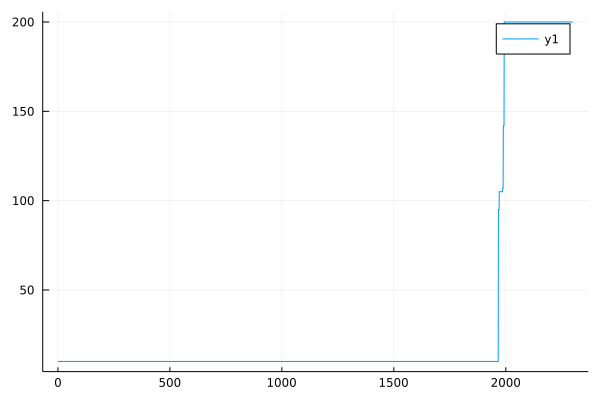

In [22]:
fits, parent = one_plus_one(layers, n_gens, play_cartpole)
plot(fits)

## 1+$\lambda$ EA

In [17]:
function one_plus_one(layers::Array, num_generations::Int, f::Function)
    fits = zeros(num_generations)
    parent = Individual(layers::Array)
    evaluate!(parent, f)
    
    for i in eachindex(fits)
        child = mutate(parent)
        evaluate!(child, f)

        if child.fitness >= parent.fitness
            parent = child
        end

        fits[i] = parent.fitness
    end
    fits, parent
end

one_plus_one (generic function with 1 method)

In [18]:
function one_plus_lambda(layers::Array, num_generations::Int, f::Function, 𝜆::Int)
    
    fits = zeros(num_generations)
    expert = Individual(layers::Array)
    evaluate!(expert, f)
    
    for i in eachindex(fits)
        population = Array{Individual}(undef, 𝜆)
        best = 1
        for j in eachindex(population)
            population[j] = mutate(expert)
            evaluate!(population[j], f) 
            if population[j].fitness > population[best].fitness
                best = j
            end
        end
        
        if population[best].fitness >= expert.fitness
            expert = population[best]
        end

        fits[i] = expert.fitness
        print(i, "/",  num_generations, " > ", expert.fitness, "\t\t\r")
    end
    fits, parent
end

one_plus_lambda (generic function with 1 method)

In [19]:
𝜆=5
n_gens = Int(round(n * log(n) / 𝜆))

460

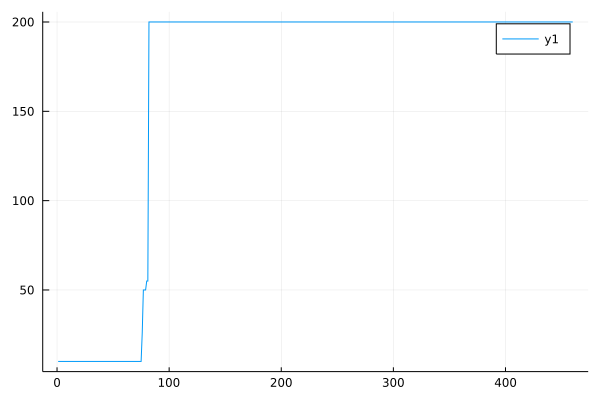

In [20]:
fits, parent = one_plus_lambda(layers, n_gens, play_cartpole, 𝜆)
plot(fits)

## Evolutionary Strategies

In [ ]:
using Statistics
using LinearAlgebra

function step(ind::Individual, f::Function; npop=20, sigma=0.5, alpha=0.1)
    P = repeat(ind.genes, 1, npop)' .+ sigma .* N
    
    population = Array{Individual}(undef, 𝜆)
    for j in eachindex(population)
        N = randn(length(ind.genes))
        
        population[j] = mutate(expert)
        evaluate!(population[j], f) 
        if population[j].fitness > population[best].fitness
            best = j
        end
    end
    
    for i in 1:npop
        new_ind = Individual(P[i, :])
        R[i] = objective(new_ind)
    end
    A = (R .- mean(R)) ./ std(R)
        
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)], R, P
end


## Atari games

For a game environment, we'll use the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment), which allows us to emulate and manipulate Atari games. There is a [Julia wrapper](https://github.com/JuliaReinforcementLearning/ArcadeLearningEnvironment.jl) which I've only tested on Linux, although the [atari-py](https://github.com/openai/atari-py) package mentions Windows support

  Resolving package versions...
  Installed Graphene_jll ────────────── v1.10.0+2
  Installed Xorg_libXtst_jll ────────── v1.2.3+4
  Installed ImageShow ───────────────── v0.2.3
  Installed Graphics ────────────────── v1.1.0
  Installed Reactive ────────────────── v0.8.3
  Installed Images ──────────────────── v0.23.3
  Installed ComputationalResources ──── v0.3.2
  Installed Libepoxy_jll ────────────── v1.5.4+1
  Installed ColorVectorSpace ────────── v0.8.7
  Installed MosaicViews ─────────────── v0.3.3
  Installed CoordinateTransformations ─ v0.6.1
  Installed IdentityRanges ──────────── v0.3.1
  Installed Xorg_libXcomposite_jll ──── v0.4.5+4
  Installed GTK3_jll ────────────────── v3.24.11+5
  Installed ImageQualityIndexes ─────── v0.2.2
  Installed Adapt ───────────────────── v3.3.0
  Installed Dbus_jll ────────────────── v1.12.16+3
  Installed RoundingIntegers ────────── v0.2.0
  Installed Missings ────────────────── v1.0.0
  Installed ImageAxes ───────────────── v0.6.9
  Installe

In [15]:
using ArcadeLearningEnvironment
ale = ALE_new()

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.


Ptr{Nothing} @0x0000000003cc2810

In [63]:
getROMList()

74-element Array{String,1}:
 "air_raid"
 "alien"
 "amidar"
 "assault"
 "asterix"
 "asteroids"
 "atlantis"
 "bank_heist"
 "battle_zone"
 "beam_rider"
 "berzerk"
 "bowling"
 "boxing"
 ⋮
 "star_gunner"
 "surround"
 "tennis"
 "time_pilot"
 "trondead"
 "tutankham"
 "up_n_down"
 "venture"
 "video_pinball"
 "wizard_of_wor"
 "yars_revenge"
 "zaxxon"

In [17]:
loadROM(ale, "ms_pacman")
actions = getMinimalActionSet(ale)

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


9-element Array{Int64,1}:
 0
 2
 3
 4
 5
 6
 7
 8
 9

In [18]:
using Images, ImageView
function get_screen(ale)
    screen = reshape(getScreenRGB(ale), (3, getScreenWidth(ale), getScreenHeight(ale))) ./ 256
    colorview(RGB, permutedims(screen, [1, 3, 2]))
end

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1278
Gtk-Message: 10:49:58.484: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:49:58.484: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:50:03.621: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:50:03.622: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:50:38.466: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:50:38.467: Failed to load module "canberra-gtk-module"


get_screen (generic function with 1 method)

In [32]:
Pkg.add("ImageMagick")

  Resolving package versions...
  Installed ImageMagick_jll ─ v6.9.10-12+3
  Installed ImageMagick ───── v1.2.1
Updating `~/.julia/environments/v1.5/Project.toml`
  [6218d12a] + ImageMagick v1.2.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [6218d12a] + ImageMagick v1.2.1
  [c73af94c] + ImageMagick_jll v6.9.10-12+3


┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278


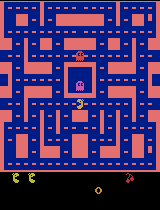

In [33]:
get_screen(ale)

In [34]:
using Reel
Reel.set_output_type("gif");

In [35]:
loadROM(ale, "ms_pacman")
frames = Frames(MIME("image/png"), fps=60)
total_reward = 0
while ~game_over(ale)
    total_reward += act(ale, rand(actions))
    push!(frames, get_screen(ale))
end
reset_game(ale)

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


In [36]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_GVA6Zt", 0x0000000000000871, 60.0, nothing)

In [37]:
loadROM(ale, "ms_pacman")

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


In [38]:
getRAM(ale)

128-element Array{UInt8,1}:
 0x00
 0x70
 0x72
 0x73
 0x00
 0x03
 0x58
 0x58
 0x58
 0x58
 0x58
 0x00
 0x50
    ⋮
 0x00
 0x3f
 0x00
 0x00
 0x00
 0x00
 0x00
 0x02
 0x42
 0xf0
 0x92
 0xd7

## Neural networks

In [41]:
Pkg.add("Flux")

  Resolving package versions...
  Installed TimerOutputs ─ v0.5.8
  Installed FillArrays ─── v0.11.7
  Installed ForwardDiff ── v0.10.18
  Installed ChainRules ─── v0.7.61
  Installed NNlib ──────── v0.7.19
  Installed Zygote ─────── v0.6.10
  Installed GPUArrays ──── v6.3.0
  Installed Functors ───── v0.2.1
  Installed Flux ───────── v0.12.1
  Installed CUDA ───────── v2.4.3
Updating `~/.julia/environments/v1.5/Project.toml`
  [587475ba] + Flux v0.12.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [ab4f0b2a] + BFloat16s v0.1.0
  [fa961155] + CEnum v0.4.1
  [052768ef] + CUDA v2.4.3
  [082447d4] + ChainRules v0.7.61
  [944b1d66] + CodecZlib v0.7.0
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.0.3
  [b552c78f] + DiffRules v1.0.2
  [e2ba6199] + ExprTools v0.1.3
  [1a297f60] + FillArrays v0.11.7
  [587475ba] + Flux v0.12.1
  [f6369f11] + ForwardDiff v0.10.18
  [d9f16b24] + Functors v0.2.1
  [0c68f7d7] + GPUArrays v6.3.0
  [61eb1bfa] + GPUCompiler v0.8.3
 

In [42]:
using Flux

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278


In [43]:
n_in = length(getRAM(ale))
n_out = length(actions)
model = Chain(
    Dense(n_in, 32),
    Dense(32, 16),
    Dense(16, n_out))

Chain(Dense(128, 32), Dense(32, 16), Dense(16, 9))

In [44]:
model(getRAM(ale) ./ typemax(UInt8))

9-element Array{Float64,1}:
 -0.22724529648029762
 -1.89177100895923
  0.0709934067812441
 -0.38435457436417414
 -2.361434134004023
  0.4234544657553655
  1.4659619278330345
 -0.7393033964214711
  0.48116419282946693

In [45]:
function play_atari(model::Chain; render=false, seed=0)
    loadROM(ale, "ms_pacman")
    if render
        frames = Frames(MIME("image/png"), fps=6)
    end
    f = 0
    total_reward = 0
    while ~game_over(ale) && f < 18000
        inputs = getRAM(ale) ./ typemax(UInt8)
        output = model(inputs)
        total_reward += act(ale, actions[argmax(output)])
        if render && mod(f, 10) == 0
            push!(frames, get_screen(ale))
        end
        f += 1
    end
    reset_game(ale)
    if render
        return total_reward, frames
    end
    total_reward
end

play_atari (generic function with 1 method)

In [46]:
total_reward, frames = play_atari(model, render=true)
total_reward

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


210

In [47]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_uc8mzt", 0x0000000000000126, 6.0, nothing)

In [48]:
param_lengths = [length(p) for p in params(model)]

6-element Array{Int64,1}:
 4096
   32
  512
   16
  144
    9

In [49]:
ndims = sum(param_lengths)

4809

In [50]:
function set_weights(x::Array{Float64})
    model = Chain(
        Dense(n_in, 32),
        Dense(32, 16),
        Dense(16, n_out))
    start = 1
    for p in params(model)
        p .= reshape(x[start:(start+length(p)-1)], size(p))
        start += length(p)
    end
    model
end

set_weights (generic function with 1 method)

In [51]:
model = set_weights(zeros(ndims))

Chain(Dense(128, 32), Dense(32, 16), Dense(16, 9))

In [52]:
model(rand(128))

9-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [53]:
function objective(x::Array{Float64})
    model = set_weights(x)
    play_atari(model)
end

objective (generic function with 1 method)

In [54]:
using Statistics
using LinearAlgebra
function step(x::Array{Float64}, objective::Function; npop=20, sigma=0.5, alpha=0.1)
    N = randn(npop, length(x))
    P = repeat(x, 1, npop)' .+ sigma .* N
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :])
    end
    A = (R .- mean(R)) ./ std(R)
        
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)], R, P
end

step (generic function with 1 method)

In [55]:
x = rand(ndims);
objective(x)

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


60

In [56]:
x, R, P = step(x, objective);

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6

In [57]:
(maximum(R), argmax(R))

(210.0, 6)

In [58]:
es_fits = []
append!(es_fits, R)
best_ind = P[argmax(R), :]
best_fit = maximum(R)

210.0

In [59]:
for i in 2:5
    x, R, P = step(x, objective)
    append!(es_fits, R)
    if maximum(R) > best_fit
        best_fit = maximum(R)
        best_ind .= P[argmax(R), :]
    end
    println(best_fit, length(es_fits))
end

210.040
230.0

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6

60


Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6

230.080
230.0

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6

100


Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6

In [60]:
model = set_weights(best_ind)
total_reward, frames = play_atari(model, render=true)

Game console created:
  ROM file:  /home/disc/p.templier/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


(230, Frames{MIME{Symbol("image/png")}}("/tmp/jl_ZQuNtL", 0x00000000000000ee, 6.0, nothing))

In [61]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_ZQuNtL", 0x00000000000000ee, 6.0, nothing)

LoadError: type String has no field join